# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Model Inputs

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None,real_dim), name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    
    return inputs_real, inputs_z

## Generator network

In [4]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    with tf.variable_scope('generator', reuse = reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation = None)
        # Leaky ReLU
        h1 = tf.maximum(alpha*h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation = None)
        out = tf.tanh(logits)
        
        return out

## Discriminator


In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse = reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation = None)
        # Leaky ReLU
        h1 = tf.maximum(h1*alpha, h1)
        
        logits = tf.layers.dense(h1, 1, activation = None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [18]:
# Size of input image to discriminator
input_size = 784 
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 256
d_hidden_size = 256
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

## Build network

In [19]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model = generator(input_z, input_size, alpha = alpha, n_units = g_hidden_size)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, alpha = alpha, n_units = d_hidden_size)
d_model_fake, d_logits_fake = discriminator(g_model, alpha = alpha, n_units = d_hidden_size, reuse = True)

## Discriminator and Generator Losses

In [20]:
# Calculate losses
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                                     labels = tf.ones_like(d_logits_real) * (1-smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                     labels = tf.zeros_like(d_logits_fake)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                labels = tf.ones_like(d_logits_fake)))

## Optimizers

In [21]:
# Optimizers
learning_rate = 0.005

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list = d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list = g_vars)

## Training

In [22]:
batch_size = 256
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.8253... Generator Loss: 1.4770
Epoch 2/100... Discriminator Loss: 1.5665... Generator Loss: 1.1077
Epoch 3/100... Discriminator Loss: 0.9049... Generator Loss: 29.2752
Epoch 4/100... Discriminator Loss: 0.4162... Generator Loss: 4.1169
Epoch 5/100... Discriminator Loss: 0.7032... Generator Loss: 3.6512
Epoch 6/100... Discriminator Loss: 0.5661... Generator Loss: 5.3832
Epoch 7/100... Discriminator Loss: 1.6596... Generator Loss: 3.1279
Epoch 8/100... Discriminator Loss: 0.4551... Generator Loss: 3.7378
Epoch 9/100... Discriminator Loss: 0.4325... Generator Loss: 5.2925
Epoch 10/100... Discriminator Loss: 0.4470... Generator Loss: 5.3823
Epoch 11/100... Discriminator Loss: 0.4496... Generator Loss: 6.1657
Epoch 12/100... Discriminator Loss: 0.4525... Generator Loss: 5.6971
Epoch 13/100... Discriminator Loss: 0.5180... Generator Loss: 4.2783
Epoch 14/100... Discriminator Loss: 0.4845... Generator Loss: 6.6019
Epoch 15/100... Discriminator Loss: 0.6154

## Training loss

Here we'll check out the training losses for the generator and discriminator.

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

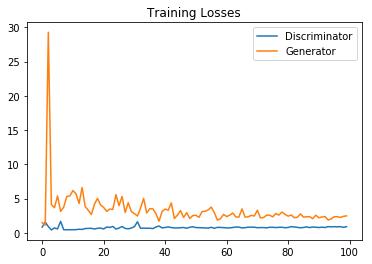

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

In [25]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [26]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 5, 7, 3, 0, 9. Since this is just a sample, it isn't representative of the full range of images this generator can make.

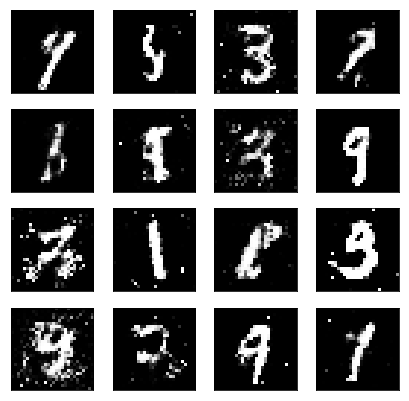

In [27]:
_ = view_samples(-1, samples)

Generated images when training, every 10 epochs

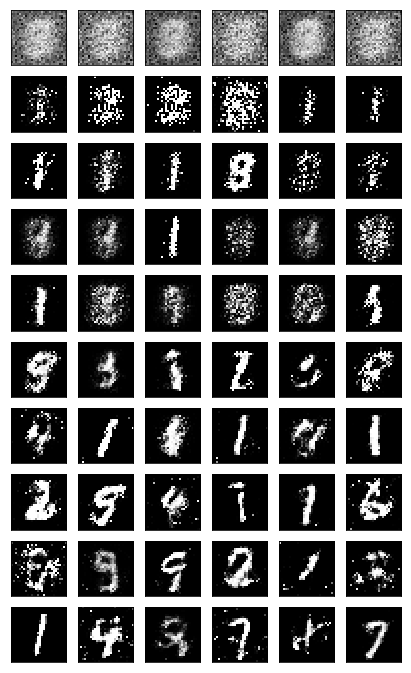

In [28]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator


INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


(<Figure size 504x504 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E094FFE80>,
       dtype=object))

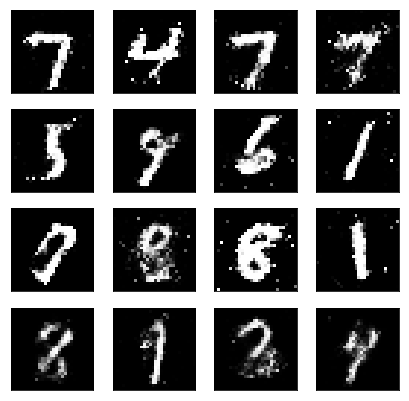

In [29]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])